In [43]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# モンテカルロシミュレーションにより円周率を導出

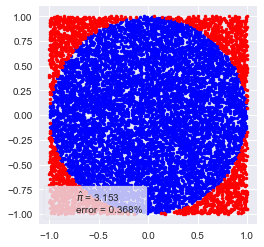

In [44]:
N=10000
x,y=np.random.uniform(-1,1,size=(2,N))

inside=(x**2+y**2)<=1
sim_pi=inside.sum()*4/N
error=abs((sim_pi-np.pi)/sim_pi)*100

# 可視化
plt.plot(x[inside],y[inside],'b.')
plt.plot(x[~inside],y[~inside],'r.')
plt.axis('square')
plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(sim_pi, error), alpha=0)
plt.legend(frameon=True)

# PyMC3で事後分布を構築

## 観測値

In [45]:
np.random.seed(123)
n_experiments=4
theta_real=0.35 # 真の値(実際には不明)
data=stats.bernoulli.rvs(p=theta_real,size=n_experiments)
data

array([1, 0, 0, 0])

## モデル構築

In [46]:
with pm.Model() as fist_model:
    # 事前分布
    theta=pm.Beta('theta',alpha=1,beta=1)
    y=pm.Bernoulli('y',p=theta,observed=data)
    
    start=pm.find_MAP()
    step=pm.Metropolis()
    trace=pm.sample(1000,step=step,start=start,njobs=6)

logp = -2.7726, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 777.11it/s]
Multiprocess sampling (6 chains in 6 jobs)
Metropolis: [theta]
Sampling 6 chains: 100%|██████████| 9000/9000 [00:01<00:00, 6952.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


## 可視化

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118673b70>,
      dtype=object)

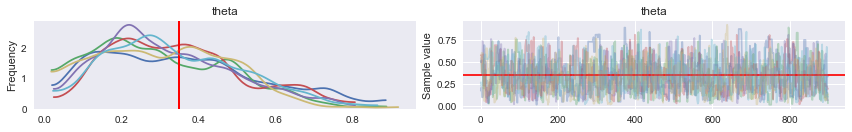

In [47]:
burnin=100
chain=trace[burnin:]
pm.traceplot(chain,lines={'theta':theta_real})

## チェーン間の分散とチェーン内の分散を比較し、サンプリングが収束しているか確認

In [48]:
pm.gelman_rubin(chain)

{'theta': 1.0054714285542652}

1.1未満なので、収束しているとする

### 視覚的に可視化

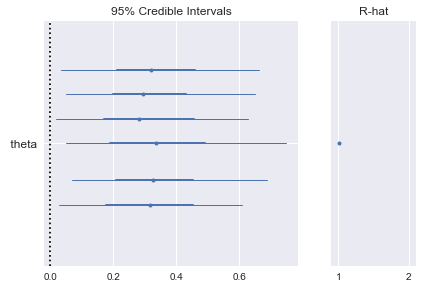

In [49]:
pm.forestplot(chain,varnames={'theta'})

## 要約統計

In [50]:
pm.summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.33182,0.179295,0.005559,0.039704,0.677197,991.905217,1.005471


## 自己相関していないかを確認

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11884f160>,
      dtype=object)

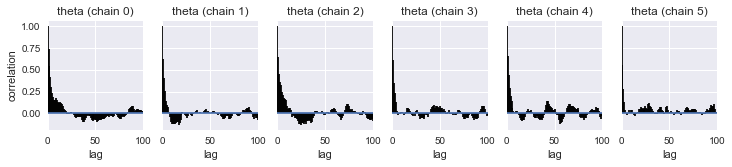

In [51]:
pm.autocorrplot(chain)

## 有効サイズ

In [52]:
pm.effective_n(chain)['theta']

991.9052174733504

## Kruschkeのグラフを可視化

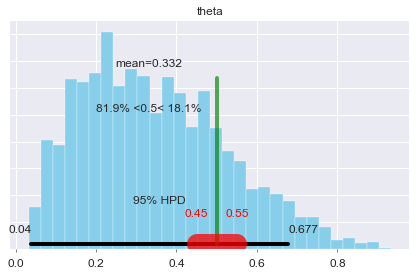

In [59]:
pm.plot_posterior(chain,kde_plot=False ,rope=[0.45,0.55],ref_val=0.5)